**UNIVERSIDADE DE SÃO PAULO**<br>
**MBA DATA SCIENCE & ANALYTICS USP/ESALQ**<br>
**SUPERVISED MACHINE LEARNING: ANÁLISE DE REGRESSÃO SIMPLES E MÚLTIPLA**<br>
**Prof. Dr. Luiz Paulo Fávero**<br>
Aluna: Luiza Batista Laquini<br>
Turma: DSA 241<br>

*coding: utf-8*

In [34]:
# In[0.1]: Instalação dos pacotes

# !pip install pandas
# !pip install numpy
# !pip install -U seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install statsmodels
# !pip install scikit-learn
# !pip install statstests

In [35]:
# In[0.2]: Importação dos pacotes

import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import matplotlib.image as mpimg # carregar imagem 
import plotly.graph_objects as go # gráficos 3D
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise; Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos - https://stats-tests.github.io/statstests/
from scipy import stats # estatística chi2
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo
                                                        #logístico multinomial
import warnings
warnings.filterwarnings('ignore')

##### CONCEITOS

**Probabilidade**:<br> 
- p = evento
- 1-p = não evento

**Chance (odds)**:<br>
- p / (1-p) "quantos pedaços"

##### MQO/OLS (Regressão Simples e Múltipla)
$\hat{y}_i = \alpha + (\beta_1 . X_1)_i + (\beta_2 . X_2)_i + ... + (\beta_k . X_k)_i$ 

##### Logística Binária
$ln(chance_i) = \alpha + (\beta_1 . X_1)_i + (\beta_2 . X_2)_i + ... + (\beta_k . X_k)_i$

onde **Logito($Z$)** = $\alpha + (\beta_1 . X_1)_i + (\beta_2 . X_2)_i + ... + (\beta_k . X_k)_i$<br>
(varia de -$\infty$ a +$\infty$)

$\therefore$<br>
$ln(\frac{p_i}{1-p_i}) = Z$<br>
$\frac{p_i}{1-p_i} = e^Z$<br>
$p_i.(1+e^Z) = e^Z$<br>
$p_i = \frac{e^Z}{1+e^Z}$<br>
$p_i = \frac{1}{1+e^-Z}$<br>
$p_i = \frac{1}{1+e^-(\alpha + (\beta_1 . X_1)_i + (\beta_2 . X_2)_i + ... + (\beta_k . X_k)_i)}$ 

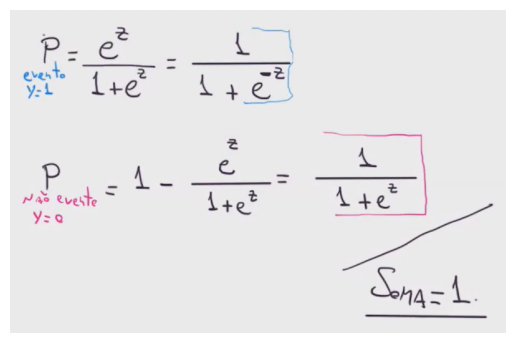

In [36]:
# Complementar
# Carregar a imagem
img = mpimg.imread('assets/output_conceito.png')

# Exibir a imagem
#plt.figure(figsize=(6,5))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

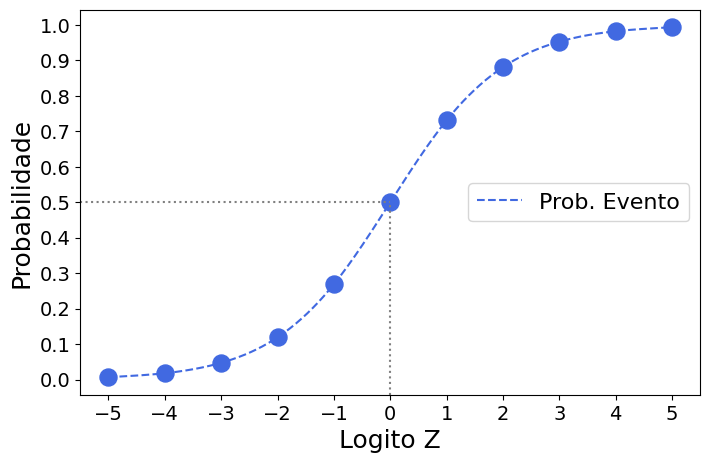

In [37]:
# In[PARTE CONCEITUAL]:
#############################################################################
#                             CURVA SIGMOIDE                                #
#############################################################################

# Estabelecendo uma função para a probabilidade de ocorrência de um evento

from math import exp

# Estabelecendo uma função para a probabilidade de ocorrência de um evento
def prob(z):
    return 1 / (1 + exp(-z))

# In[SIGMOIDE]: Plotando a curva sigmoide teórica de ocorrência de um evento
#para um range do logito z entre -5 e +5

logitos = []
probs = []

for i in np.arange(-5, 6):
    logitos.append(i)
    probs.append(prob(i))
    
df = pd.DataFrame({'logito': logitos, 'probs': probs})

# Interpolação spline (smooth probability line)
spline = UnivariateSpline(df['logito'], df['probs'], s=0)

logitos_smooth = np.linspace(df['logito'].min(), df['logito'].max(), 500)
probs_smooth = spline(logitos_smooth)

plt.figure(figsize=(8,5))
plt.plot(logitos_smooth, probs_smooth, color='royalblue',
         linestyle='--', label='Prob. Evento')
plt.scatter(df['logito'], df['probs'], color='royalblue', marker='o', s=150)
plt.axhline(y = df.probs.mean(), color = 'grey', linestyle = ':', xmax = .5)
plt.axvline(x = 0, color = 'grey', linestyle=':', ymax = 0.5)
plt.xlabel("Logito Z", fontsize=18)
plt.ylabel("Probabilidade", fontsize=18)
plt.xticks(np.arange(-5, 6), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)
plt.legend(fontsize=16, loc='center right')
plt.show()

Assíntotas em 0 e 1 (nunca ultrapassam esses valores)

In [38]:
# In[EXEMPLO 1]:
#############################################################################
#                      REGRESSÃO LOGÍSTICA BINÁRIA                          #                  
#               EXEMPLO 1 - CARREGAMENTO DA BASE DE DADOS                   #
#############################################################################

df_atrasado = pd.read_csv('data/atrasado.csv',delimiter=',')
df_atrasado.head(3)

,estudante,atrasado,dist,sem
0,Gabriela,0,12.5,7
1,Patricia,0,13.3,10
2,Gustavo,0,13.4,8


In [39]:
# Características das variáveis do dataset
df_atrasado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    int64  
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB


In [40]:
# Estatísticas univariadas
df_atrasado.describe()

,atrasado,dist,sem
count,100.000000,100.000000,100.000000
mean,0.590000,14.073000,10.210000
std,0.494311,4.330112,1.578229
min,0.000000,1.000000,5.000000
25%,0.000000,12.000000,10.000000
50%,1.000000,13.350000,10.000000
75%,1.000000,16.125000,10.000000
max,1.000000,29.000000,18.000000


In [41]:
# In[1.1]: Tabela de frequências absolutas da variável 'atrasado'

df_atrasado['atrasado'].value_counts().sort_index()

atrasado
0    41
1    59
Name: count, dtype: int64

In [42]:
# In[1.2]: Estimação de um modelo logístico binário pela função 'smf.glm'
#('statsmodels.formula.api')

modelo_atrasos = smf.glm(formula='atrasado ~ dist + sem', data=df_atrasado,
                         family=sm.families.Binomial()).fit()

# Parâmetros do 'modelo_atrasos'
print(modelo_atrasos.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               atrasado   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50.466
Date:                Wed, 04 Sep 2024   Deviance:                       100.93
Time:                        20:06:59   Pearson chi2:                     86.7
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2913
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -26.1665      8.442     -3.100      0.0

In [48]:
# In[1.3]: Outputs do modelo pela função 'summary_col'

sc = summary_col([modelo_atrasos],
            model_names=["MODELO"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.3f}".format(x.llf)
        })

print(sc)


             MODELO  
---------------------
Intercept -26.1665***
          (8.4420)   
dist      0.1904**   
          (0.0764)   
sem       2.3629***  
          (0.7951)   
N         100        
Log-lik   -50.466    
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


In [44]:
# In[1.4]: Fazendo predições para o 'modelo_atrasos'.
#Exemplo: qual a probabilidade média de se chegar atrasado quando o
#trajeto tem 7 km e passa-se por 10 semáforos no percurso?

modelo_atrasos.predict(pd.DataFrame({'dist':[7], 'sem':[10]}))

0    0.230566
dtype: float64

In [45]:
# In[1.5]: Construção de uma matriz de confusão

# Adicionando os valores previstos de probabilidade na base de dados
df_atrasado['phat'] = modelo_atrasos.predict()

# Visualização da base de dados com a variável 'phat'
df_atrasado

,estudante,atrasado,dist,sem,phat
0,Gabriela,0,12.5,7,0.000712
1,Patricia,0,13.3,10,0.498561
2,Gustavo,0,13.4,8,0.008903
3,Leticia,0,23.5,7,0.005751
4,Luiz Ovidio,0,9.5,8,0.004257
...,...,...,...,...,...
95,Sheila,1,24.0,10,0.884040
96,Pedro,1,10.0,10,0.346606
97,Horacio,1,9.4,10,0.321210
98,Leandro,1,14.2,10,0.541301


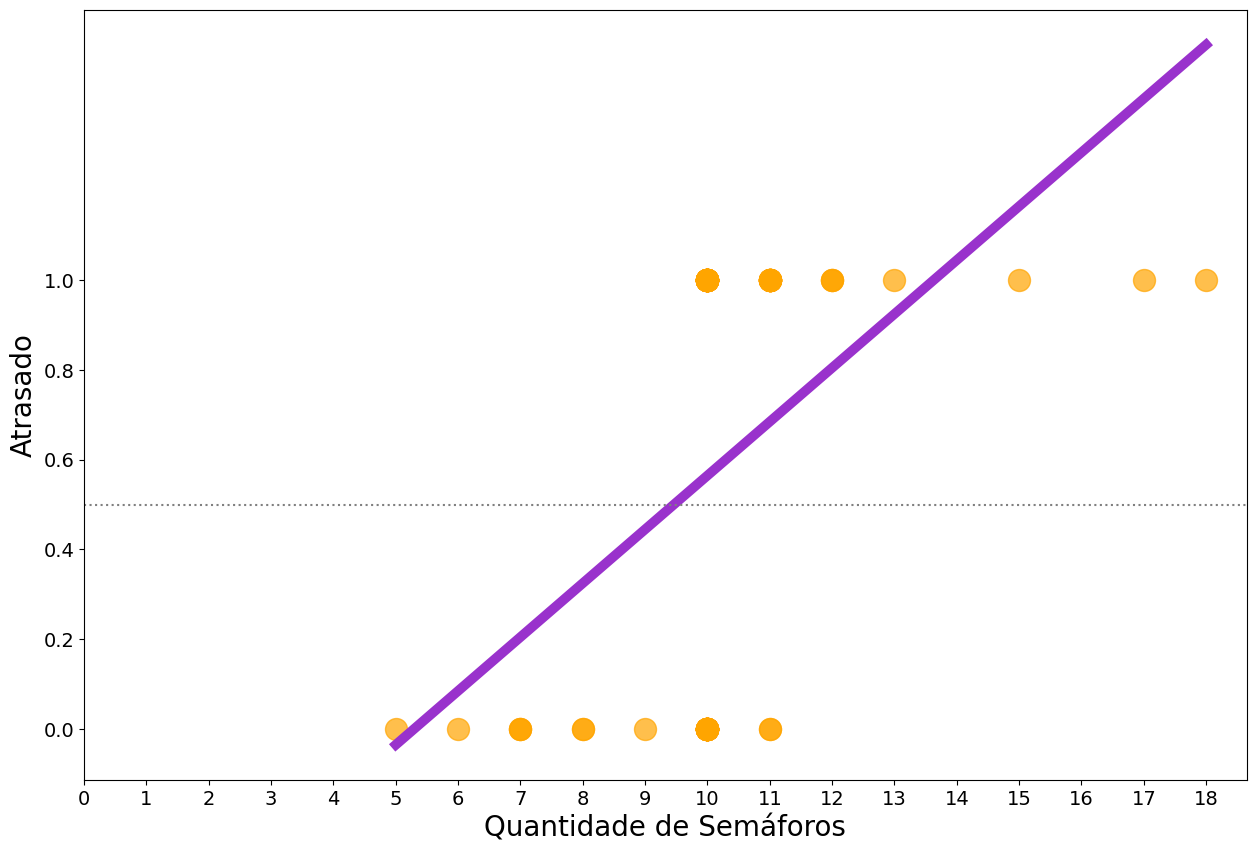

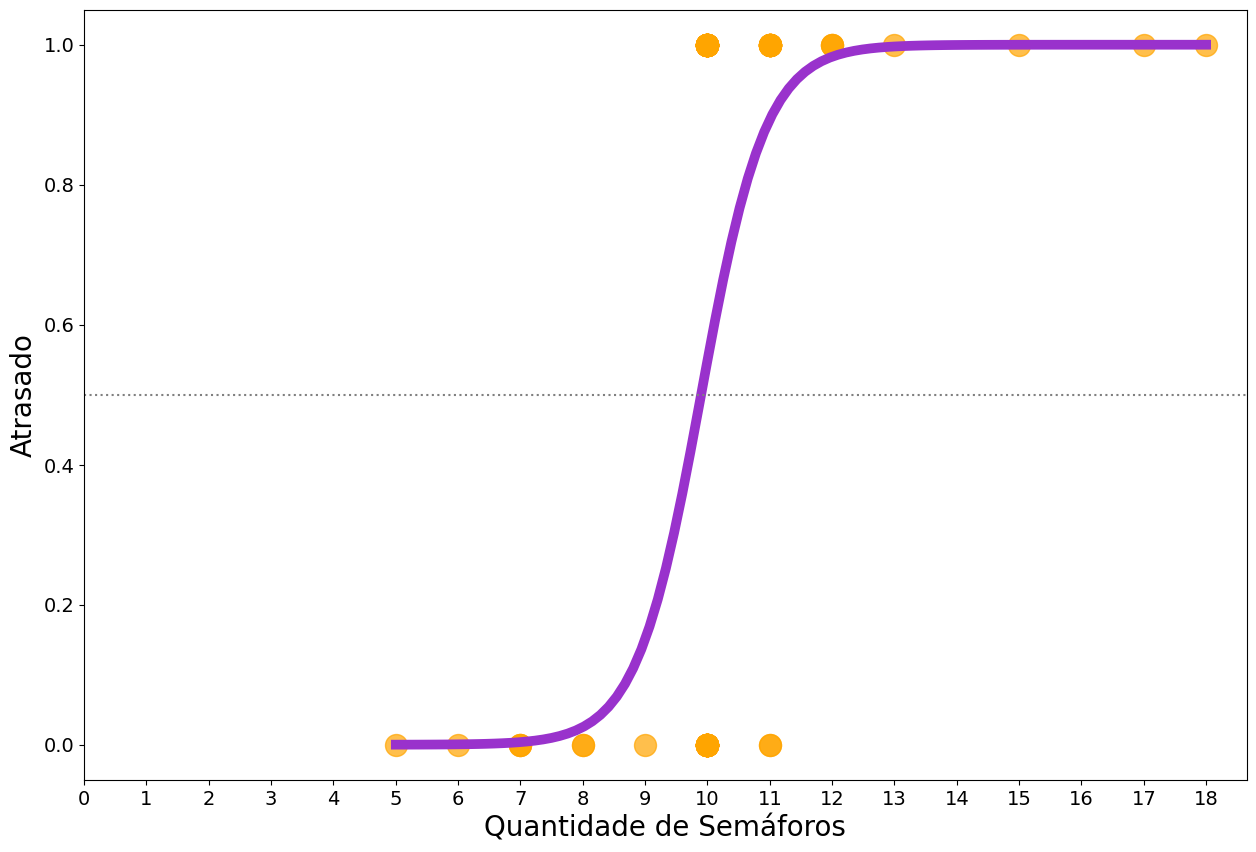

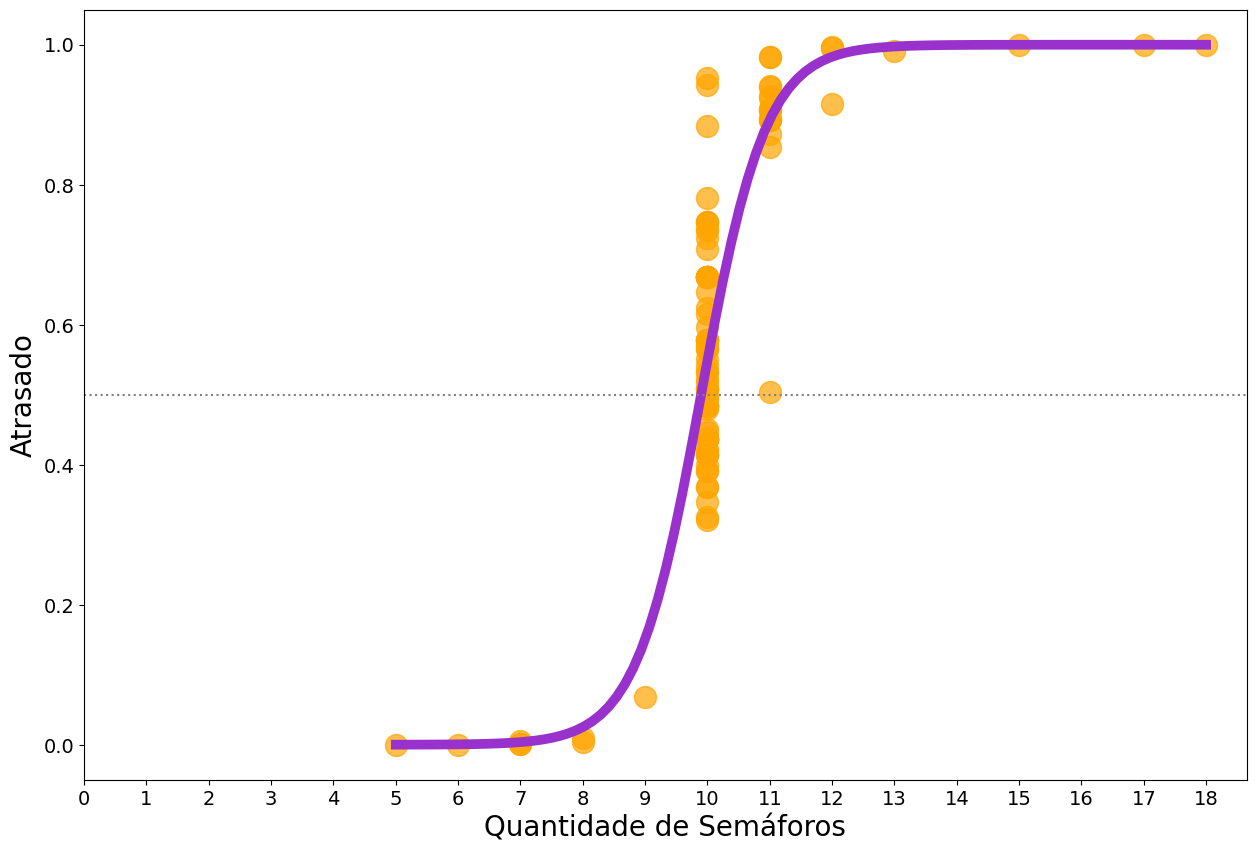

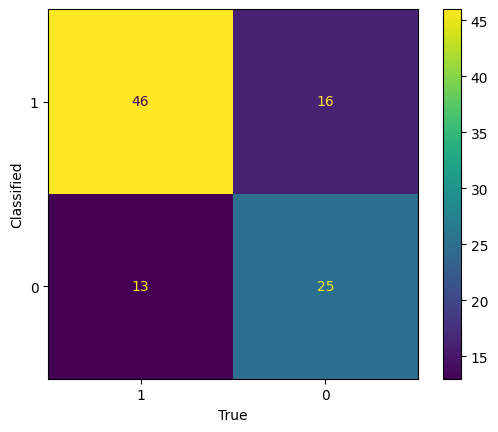

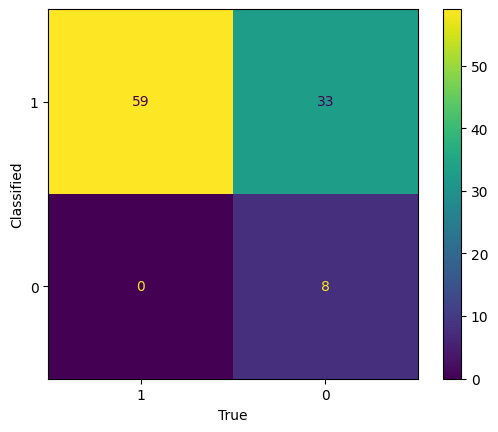

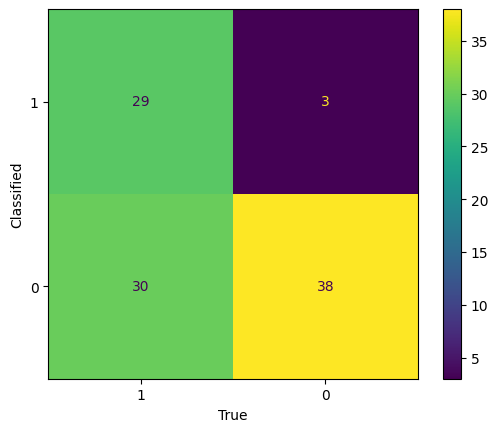

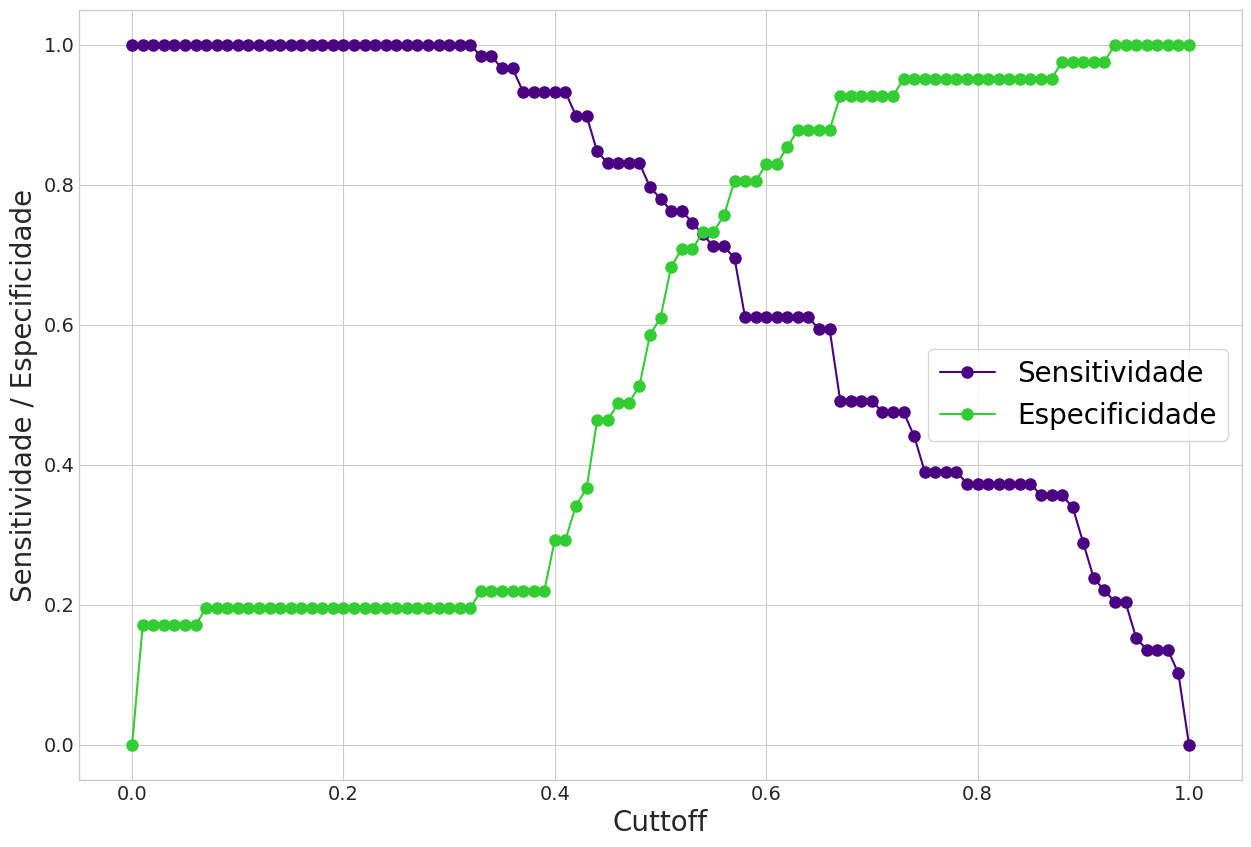

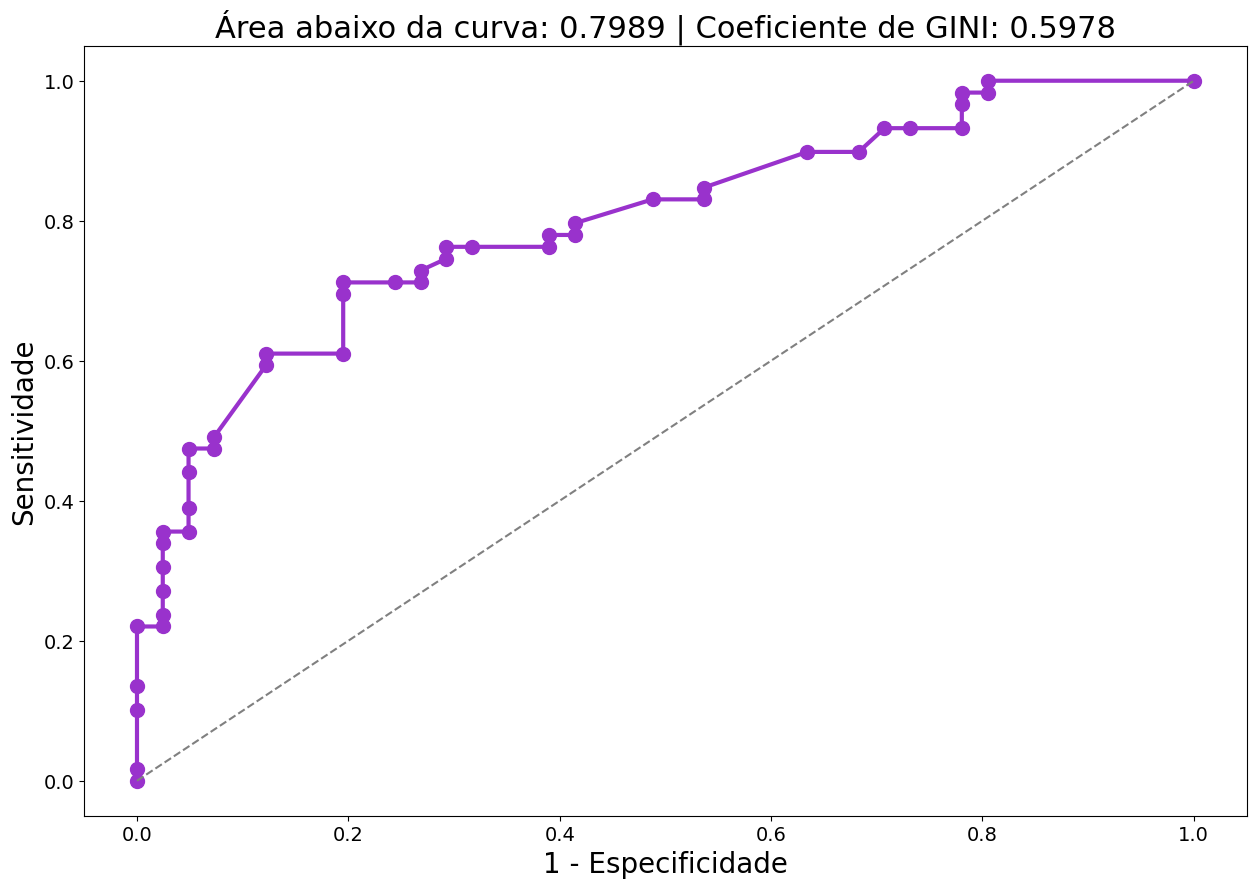

FileNotFoundError: [Errno 2] No such file or directory: 'challenger.csv'

In [46]:
# In[1.6]: Gráficos com ajustes entre a variável dependente e a variável 'sem'
    
# Ajuste linear entre a variável dependente e a variável 'sem' (Gráfico errado:
#apenas para fins didáticos)

plt.figure(figsize=(15,10))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'],
            ci=None, marker='o',
            scatter_kws={'color':'orange', 's':250, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=20)
plt.ylabel('Atrasado', fontsize=20)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show

# In[1.7]: Ajuste logístico determinístico entre a variável dependente e a
#variável 'sem'

# Sigmoide

plt.figure(figsize=(15,10))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'],
            ci=None, marker='o', logistic=True,
            scatter_kws={'color':'orange', 's':250, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=20)
plt.ylabel('Atrasado', fontsize=20)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show

# In[1.8]: Ajuste logístico probabilístico entre a variável dependente e a
#variável 'sem'

# Sigmoide

plt.figure(figsize=(15,10))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['phat'],
            ci=None, marker='o', logistic=True,
            scatter_kws={'color':'orange', 's':250, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=20)
plt.ylabel('Atrasado', fontsize=20)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show

# In[1.9]: Construção de função para a definição da matriz de confusão

from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    # Visualização dos principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

# In[1.10]: Matrizes de confusão propriamente ditas

# Matriz de confusão para cutoff = 0.5
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.5)

# Matriz de confusão para cutoff = 0.3
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.3)

# Matriz de confusão para cutoff = 0.7
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.7)

# In[1.11]: Igualando critérios de especificidade e de sensitividade

# Tentaremos estabelecer um critério que iguale a probabilidade de
#acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de
#acerto daqueles que não chegarão atrasados (especificidade).

# ATENÇÃO: o que será feito a seguir possui fins didáticos, apenas. DE NENHUMA
#FORMA, o procedimento garante a maximização da acurácia do modelo!

# Criação da função 'espec_sens' para a construção de um dataset com diferentes
#valores de cutoff, sensitividade e especificidade:

def espec_sens(observado,predicts):
    
    # Adicionar objeto com os valores dos predicts
    values = predicts.values
    
    # Range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

# In[1.12]: Até o momento, foram extraídos 3 vetores: 'sensitividade',
#'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
#os vetores mencionados (dataframe 'dados_plotagem')

dados_plotagem = espec_sens(observado = df_atrasado['atrasado'],
                            predicts = df_atrasado['phat'])
dados_plotagem

# In[1.13]: Plotagem de um gráfico que mostra a variação da especificidade e da
#sensitividade em função do cutoff

plt.figure(figsize=(15,10))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o',
         color='indigo', markersize=8)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=20)
plt.ylabel('Sensitividade / Especificidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=20)
plt.show()

# In[1.14]: Construção da curva ROC

from sklearn.metrics import roc_curve, auc

# Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds =roc_curve(df_atrasado['atrasado'], df_atrasado['phat'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensitividade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()


# In[EXEMPLO 2]:
#############################################################################
#           REGRESSÃO LOGÍSTICA BINÁRIA E PROCEDIMENTO STEPWISE             #        
#                EXEMPLO 2 - CARREGAMENTO DA BASE DE DADOS                  #
#############################################################################

df_challenger = pd.read_csv('challenger.csv',delimiter=',')
df_challenger

# Características das variáveis do dataset
df_challenger.info()

# Estatísticas univariadas
df_challenger.describe()

# desgaste: quantidade de vezes em que ocorreu stress térmico
# temperatura: temperatura de lançamento (graus ºF)
# pressão: pressão de verificação de vazamento (psi: libra-força por
    #polegada ao quadrado)
# t: teste para o lançamento (id)

# In[2.1]: Criação da variável dependente binária 'falha'

# Não há uma variável binária para servir como uma variável dependente, certo?
# Então vamos criá-la, considerando a ocorrência de desgastes de peças como a
#ocorrência de um evento que chamaremos de 'falha':

df_challenger.loc[df_challenger['desgaste'] != 0 , 'falha'] = 1
df_challenger.loc[df_challenger['desgaste'] == 0, 'falha'] = 0

# Transformando a variável 'falha' para o tipo 'int' (poderia também deixar
#como 'float'), a fim de que seja possível estimar o modelo por meio da
#função 'sm.Logit.from_formula'

df_challenger.info()

df_challenger['falha'] = df_challenger['falha'].astype('int64')

df_challenger.info()

df_challenger

# In[2.2]: Gráfico 'pairplot' com scatters e KDEs por 'falha'

cores_desejadas = {0: 'springgreen', 1: 'magenta'}

g = sns.pairplot(df_challenger[['falha','temperatura','pressão']], hue='falha',
                 palette=cores_desejadas)
g.fig.set_size_inches(8, 6)
plt.show()


# In[2.3]: Estimação do modelo logístico binário pela função 'sm.Logit.from_formula'
#('statsmodels.api')

# O modelo a seguir também pode ser estimado por meio da função 'smf.glm'
#('statsmodels.formula.api')

modelo_challenger = sm.Logit.from_formula('falha ~ temperatura + pressão',
                                          df_challenger).fit()

# Parâmetros do 'modelo_challenger'
modelo_challenger.summary()

# In[2.4]: Procedimento Stepwise

# Estimação do modelo por meio do procedimento Stepwise
step_challenger = stepwise(modelo_challenger, pvalue_limit=0.05)

# In[2.5]: Fazendo predições para o modelo 'step_challenger'

# Exemplo 1: qual a probabilidade média de falha a 70ºF (~21.11ºC)?
step_challenger.predict(pd.DataFrame({'temperatura':[70]}))

# Exemplo 2: qual a probabilidade média de falha a 77ºF (25ºC)?
step_challenger.predict(pd.DataFrame({'temperatura':[77]}))

# Exemplo 3: qual a probabilidade média de falha a 34ºF (~1.11ºC)?
# Temperatura no momento do lançamento
step_challenger.predict(pd.DataFrame({'temperatura':[34]}))

# In[2.6]: Atribuindo uma coluna no dataframe para os resultados

df_challenger['phat'] = step_challenger.predict()

df_challenger

# In[2.7]: Construção da sigmoide
# Probabilidade de evento em função da variável 'temperatura'    

plt.figure(figsize=(15,10))
sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 0],
                y=df_challenger['falha'][df_challenger['falha'] == 0],
                color='springgreen', alpha=0.7, s=250, label='Falha = 0')
sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 1],
                y=df_challenger['falha'][df_challenger['falha'] == 1],
                color='magenta', alpha=0.7, s=250, label='Falha = 1')
sns.regplot(x=df_challenger['temperatura'], y=df_challenger['falha'],
            logistic=True, ci=None, scatter=False,
            line_kws={'color': 'indigo', 'linewidth': 7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Temperatura em ºF', fontsize=20)
plt.ylabel('Probabilidade de Falha', fontsize=20)
plt.xticks(np.arange(df_challenger['temperatura'].min(),
                     df_challenger['temperatura'].max() + 0.01, 3),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(fontsize=20, loc='center right')
plt.show()

# In[2.8]: Nossa homenagem aos astronautas

from PIL import Image
import requests
from io import BytesIO

url = "https://img.ibxk.com.br///2016/01/29/29182307148581.jpg?w=1200&h=675&mode=crop&scale=both"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.show()    


# In[EXEMPLO 3]:
#############################################################################
#  REGRESSÃO LOGÍSTICA BINÁRIA COM VARIÁVEIS EXPLICATIVAS QUANTI E QUALIS   #
#                EXEMPLO 3 - CARREGAMENTO DA BASE DE DADOS                  #
#############################################################################

df_fidelidade = pd.read_csv('dados_fidelidade.csv',delimiter=',')
df_fidelidade

# Características das variáveis do dataset
df_fidelidade.info()

# Estatísticas univariadas
df_fidelidade.describe()

# In[3.1]: Alteração dos tipos das variáveis não quantitativas no dataframe

# Transformação do 'id' para o tipo 'str'
df_fidelidade['id'] = df_fidelidade['id'].astype('str')

# Transformação das variáveis explicativas qualitativas para o tipo 'object'
df_fidelidade['atendimento'] = df_fidelidade['atendimento'].astype('object')
df_fidelidade['sortimento'] = df_fidelidade['sortimento'].astype('object')
df_fidelidade['acessibilidade'] = df_fidelidade['acessibilidade'].astype('object')
df_fidelidade['preço'] = df_fidelidade['preço'].astype('object')

# Características das variáveis do dataset
df_fidelidade.info()

# Estatísticas univariadas
df_fidelidade.describe()

# In[3.2]: Tabela de frequências absolutas das variáveis qualitativas referentes
#aos atributos da loja na percepção dos consumidores

df_fidelidade['fidelidade'].value_counts().sort_index()
df_fidelidade['sexo'].value_counts().sort_index()
df_fidelidade['atendimento'].value_counts().sort_index()
df_fidelidade['sortimento'].value_counts().sort_index()
df_fidelidade['acessibilidade'].value_counts().sort_index()
df_fidelidade['preço'].value_counts().sort_index()

# In[3.3]: Note que a variável Y 'fidelidade' está definida como objeto
#(PROBLEMA!!!)

# Transformando a variável Y para 0 e 1 e para o tipo 'int' (poderia também
#ser do tipo 'float'), a fim de que seja possível estimar o modelo por meio
#da função 'sm.Logit.from_formula'

df_fidelidade.loc[df_fidelidade['fidelidade']=='sim', 'fidelidade'] = 1
df_fidelidade.loc[df_fidelidade['fidelidade']=='nao', 'fidelidade'] = 0

df_fidelidade['fidelidade'] = df_fidelidade['fidelidade'].astype('int64')

df_fidelidade

# In[3.4]: Dummizando as variáveis 'atendimento', 'sortimento', 'acessibilidade',
#'preço' e 'sexo'. O código abaixo, automaticamente, fará:
# a) a dummização das variáveis originais;
# b) a remoção das variáveis dummizadas originais;
# c) a definição das categorias de label 1 de cada variável original como
#categorias de referência, por meio do argumento 'drop_first=True'.

df_fidelidade_dummies = pd.get_dummies(df_fidelidade,
                                       columns=['atendimento',
                                                'sortimento',
                                                'acessibilidade',
                                                'preço',
                                                'sexo'],
                                       dtype=int,
                                       drop_first=True)

df_fidelidade_dummies

# In[3.5]: Estimação do modelo logístico binário

# Sugestão de uso neste caso, dada a existência de muitas dummies no dataframe
# Definição da fórmula utilizada no modelo

lista_colunas = list(df_fidelidade_dummies.drop(columns=['id',
                                                         'fidelidade']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "fidelidade ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

# Modelo propriamente dito
modelo_fidelidade = sm.Logit.from_formula(formula_dummies_modelo,
                                               df_fidelidade_dummies).fit()

# Parâmetros do 'modelo_fidelidade'
modelo_fidelidade.summary()

# In[3.6]: Procedimento Stepwise

#Estimação do modelo por meio do procedimento Stepwise
step_modelo_fidelidade = stepwise(modelo_fidelidade, pvalue_limit=0.05)

# In[3.7]: Construção de função para a definição da matriz de confusão

from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

# In[3.8]: Construção da matriz de confusão

# Adicionando os valores previstos de probabilidade na base de dados
df_fidelidade_dummies['phat'] = step_modelo_fidelidade.predict()

# Matriz de confusão para cutoff = 0.5
matriz_confusao(observado=df_fidelidade_dummies['fidelidade'],
                predicts=df_fidelidade_dummies['phat'],
                cutoff=0.50)

# In[3.9]: Igualando critérios de especificidade e de sensitividade

# Tentaremos estabelecer um critério que iguale a probabilidade de
#acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de
#acerto daqueles que não chegarão atrasados (especificidade).

# ATENÇÃO: o que será feito a seguir possui fins didáticos, apenas. DE NENHUMA
#FORMA o procedimento garante a maximização da acurácia do modelo!

# Criação da função 'espec_sens' para a construção de um dataset com diferentes
#valores de cutoff, sensitividade e especificidade:

def espec_sens(observado,predicts):
    
    # adicionar objeto com os valores dos predicts
    values = predicts.values
    
    # range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

# In[3.10]: Até o momento, foram extraídos 3 vetores: 'sensitividade',
#'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
#os vetores mencionados

dados_plotagem = espec_sens(observado = df_fidelidade_dummies['fidelidade'],
                            predicts = df_fidelidade_dummies['phat'])
dados_plotagem

# In[3.11]: Plotagem de um gráfico que mostra a variação da especificidade e da
#sensitividade em função do cutoff

plt.figure(figsize=(15,10))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o',
         color='indigo', markersize=8)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=20)
plt.ylabel('Sensitividade / Especificidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=20)
plt.show()

# In[3.12]: Construção da curva ROC

from sklearn.metrics import roc_curve, auc

# Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds =roc_curve(df_fidelidade_dummies['fidelidade'],
                                df_fidelidade_dummies['phat'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensitividade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()


# In[EXEMPLO 4]:
#############################################################################
#                      REGRESSÃO LOGÍSTICA MULTINOMIAL                      #
#                 EXEMPLO 4 - CARREGAMENTO DA BASE DE DADOS                 #
#############################################################################

df_atrasado_multinomial = pd.read_csv('atrasado_multinomial.csv',delimiter=',')
df_atrasado_multinomial

# Características das variáveis do dataset
df_atrasado_multinomial.info()

# Estatísticas univariadas
df_atrasado_multinomial.describe()

# In[4.1]: Note que a variável Y 'atrasado' está definida como objeto

# Tabela de frequências absolutas da variável 'atrasado' com labels
df_atrasado_multinomial['atrasado'].value_counts().sort_index()

# Criando uma variável 'atrasado2' a partir da variável 'atrasado',
#com labels iguais a 0, 1 e 2 e com tipo 'int' (poderia também ser do tipo
#'float'), a fim de que seja possível estimar o modelo por meio
#da função 'MNLogit' do pacote 'statsmodels.discrete.discrete_model'

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'nao chegou atrasado',
                            'atrasado2'] = 0 #categoria de referência

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'chegou atrasado primeira aula',
                            'atrasado2'] = 1

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'chegou atrasado segunda aula',
                            'atrasado2'] = 2

# Definição do tipo 'int' para a variável dependente 'atrasado2'
df_atrasado_multinomial['atrasado2'] =\
    df_atrasado_multinomial['atrasado2'].astype('int64')

df_atrasado_multinomial.info()

df_atrasado_multinomial

# In[4.2]: Estimação do modelo logístico multinomial

x = df_atrasado_multinomial.drop(columns=['estudante','atrasado','atrasado2'])
y = df_atrasado_multinomial['atrasado2']

# Esse pacote precisa que a constante seja definida pelo usuário
X = sm.add_constant(x)

# Estimação do modelo - função 'MNLogit' ('statsmodels.discrete.discrete_model')
modelo_atrasado = MNLogit(endog=y, exog=X).fit()

# Parâmetros do modelo 'modelo_atrasado'
modelo_atrasado.summary()

# In[4.3]: Vamos definir uma função 'Qui2' para se extrair a estatística geral
# do modelo

def Qui2(modelo_multinomial):
    maximo = modelo_multinomial.llf
    minimo = modelo_multinomial.llnull
    qui2 = -2*(minimo - maximo)
    pvalue = stats.distributions.chi2.sf(qui2,1)
    df = pd.DataFrame({'Qui quadrado':[qui2],
                       'pvalue':[pvalue]})
    return df

# In[4.4]: Estatística geral do 'modelo_atrasado'

Qui2(modelo_atrasado)

# In[4.5]: Fazendo predições para o 'modelo_atrasado'

# Exemplo: qual a probabilidade média de atraso para cada categoria da
#variável dependente, se o indivíduo tiver que percorrer 22km e passar
#por 12 semáforos?

# No nosso exemplo, temos os seguintes labels para a variável 'atrasado2':
# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

resultado = modelo_atrasado.predict(pd.DataFrame({'const':[1],
                                                   'dist':[22],
                                                   'sem':[12]})).round(4)

resultado

# Uma maneira de identificar a classe do resultado de acordo com o 'predict'
resultado.idxmax(axis=1)

# In[4.6]: Adicionando as probabilidades de ocorrência de cada uma das
#categorias de Y definidas pela modelagem ao dataframe original, bem como a
#respectiva classificação

# Probabilidades de ocorrência das três categoriais
# Definição do array 'phats':
phats = modelo_atrasado.predict()
phats

# Transformação do array 'phats' para o dataframe 'phats':
phats = pd.DataFrame(phats)
phats

# Concatenando o dataframe original com o dataframe 'phats':
df_atrasado_multinomial = pd.concat([df_atrasado_multinomial, phats], axis=1)
df_atrasado_multinomial

# Analisando o resultado de acordo com a categoria de resposta:
predicao = phats.idxmax(axis=1)
predicao

# Adicionando a categoria de resposta 'predicao' ao dataframe original,
#por meio da criação da variável 'predicao'
df_atrasado_multinomial['predicao'] = predicao
df_atrasado_multinomial

# Criando a variável 'predicao_label' a partir da variável 'predicao',
#respeitando os seguintes rótulos:
# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==0,
                            'predicao_label'] ='não chegou atrasado'
df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==1,
                            'predicao_label'] ='chegou atrasado primeira aula'
df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==2,
                            'predicao_label'] ='chegou atrasado segunda aula'

df_atrasado_multinomial

# In[4.7]: Criação de tabela para cálculo da eficiência global do modelo

# Criando uma tabela para comparar as ocorrências reais com as predições
table = pd.pivot_table(df_atrasado_multinomial,
                       index=['predicao_label'],
                       columns=['atrasado'],
                       aggfunc='size')
table

# Substituindo 'NaN' por zero
table = table.fillna(0)
table

# In[4.8]: Visualização, para fins didáticos, do objeto 'table' (dataframe)
#no ambiente Plots

from tabulate import tabulate
tabela = tabulate(table, headers='keys', tablefmt='grid', numalign='center')

plt.figure(figsize=(8, 3))
plt.text(0.1, 0.1, tabela, {'family': 'monospace', 'size': 15})
plt.axis('off')
plt.show()

# In[4.9]: Eficiência global do modelo propriamente dita

# Transformando o dataframe 'table' para 'array', para que seja possível
#estabelecer o atributo 'diagonal'
table = table.to_numpy()
table

# Eficiência global do modelo
acuracia = table.diagonal().sum()/table.sum()
acuracia

# In[4.10]: Plotagens das probabilidades

# Plotagem das smooth probability lines para a variável 'dist'

# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

plt.figure(figsize=(15,10))

# Plot para "não chegou atrasado"
sns.regplot(x='dist', y=df_atrasado_multinomial[0],
            data=df_atrasado_multinomial, ci=False, order=4,
            line_kws={'color':'indigo', 'linewidth':4,
                      'label':'não chegou atrasado'},
            scatter_kws={'color':'indigo', 's':80, 'alpha':0.5})

# Plot para "chegou atrasado na primeira aula"
sns.regplot(x='dist', y=df_atrasado_multinomial[1],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkgreen', 'linewidth':4,
                      'label':'chegou atrasado na primeira aula'},
            scatter_kws={'color':'darkgreen', 's':80, 'alpha':0.5})

# Plot para "chegou atrasado na segunda aula"
sns.regplot(x='dist', y=df_atrasado_multinomial[2],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkorange', 'linewidth':4,
                      'label':'chegou atrasado na segunda aula'},
            scatter_kws={'color':'darkorange', 's':80, 'alpha':0.5})

plt.xlabel('Distância Percorrida', fontsize=18)
plt.ylabel('Probabilidades', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='center left', fontsize=14)
plt.show()

# In[4.11]: Plotagens das probabilidades

# Plotagem das smooth probability lines para a variável 'sem'

# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

plt.figure(figsize=(15,10))

# Plot para "não chegou atrasado"
sns.regplot(x='sem', y=df_atrasado_multinomial[0],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'indigo', 'linewidth':4,
                      'label':'não chegou atrasado'},
            scatter_kws={'color':'indigo', 's':80, 'alpha':0.5})

# Plot para "chegou atrasado na primeira aula"
sns.regplot(x='sem', y=df_atrasado_multinomial[1],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkgreen', 'linewidth':4,
                      'label':'chegou atrasado na primeira aula'},
            scatter_kws={'color':'darkgreen', 's':80, 'alpha':0.5})

# Plot para "chegou atrasado na segunda aula"
sns.regplot(x='sem', y=df_atrasado_multinomial[2],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkorange', 'linewidth':4,
                      'label':'chegou atrasado na segunda aula'},
            scatter_kws={'color':'darkorange', 's':80, 'alpha':0.5})

plt.xlabel('Quantidade de Semáforos', fontsize=18)
plt.ylabel('Probabilidades', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', fontsize=14)
plt.show()

# In[4.12]: Plotagem tridimensional para cada probabilidade de ocorrência de
#cada categoria da variável dependente

# Probabilidades de não se chegar atrasado (função 'go' do pacote 'plotly')

import plotly.io as pio
pio.renderers.default = 'browser'

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[0],
    opacity=1, intensity=df_atrasado_multinomial[0],
    colorscale="Viridis")

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(
                        xaxis_title='dist',
                        yaxis_title='sem',
                        zaxis_title='não chegou atrasado'))

plot_figure.show()

# In[4.13]: Plotagem tridimensional para cada probabilidade de ocorrência de
#cada categoria da variável dependente

# Probabilidades de se chegar atrasado à primeira aula (função 'go' do pacote
#'plotly')

pio.renderers.default = 'browser'

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[1],
    opacity=1, intensity=df_atrasado_multinomial[1],
    colorscale="Viridis")

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(
                        xaxis_title='dist',
                        yaxis_title='sem',
                        zaxis_title='chegou atrasado à primeira aula'))

plot_figure.show()

# In[4.14]: Plotagem tridimensional para cada probabilidade de ocorrência de
#cada categoria da variável dependente

# Probabilidades de se chegar atrasado à segunda aula (função 'go' do pacote
#'plotly')

pio.renderers.default = 'browser'

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[2],
    opacity=1, intensity=df_atrasado_multinomial[2],
    colorscale="Viridis")

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(
                        xaxis_title='dist',
                        yaxis_title='sem',
                        zaxis_title='chegou atrasado à segunda aula'))

plot_figure.show()

# In[4.15]: Visualização das sigmoides tridimensionais em um único gráfico

pio.renderers.default = 'browser'

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[0],
    opacity=1,
    color='indigo')

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

trace_1 = go.Mesh3d(
            x=df_atrasado_multinomial['dist'], 
            y=df_atrasado_multinomial['sem'],
            z=df_atrasado_multinomial[1],
            opacity=1,
            color='darkgreen')

plot_figure.add_trace(trace_1)

trace_2 = go.Mesh3d(
            x=df_atrasado_multinomial['dist'], 
            y=df_atrasado_multinomial['sem'],
            z=df_atrasado_multinomial[2],
            opacity=1,
            color='darkorange')


plot_figure.add_trace(trace_2)

plot_figure.update_layout(
    template='plotly_dark',
    scene = dict(
        xaxis_title='dist',
        yaxis_title='sem',
        zaxis_title='probabilidades')
    )

plot_figure.show()

################################## FIM ######################################